In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
import pandas as pd
from collections import defaultdict, OrderedDict
from tqdm import tqdm
import pickle
from scipy.stats import pearsonr

sns.set_style('whitegrid')

# Pairwise DESeq2 Method

**Problem:** DESeq2 is traditionally run as a single comparison between two groups. The input is an expression matrix of genes by samples, a vector identifying which samples belong to which group, and optionally, additional vectors describing covariate relationships in the data. Unfortunately, when trying to run a large number of samples, the runtime of DESeq2 increases exponetially with respect to the number of cores on the machine.

Performing DESeq2 in a pairwise fashion, where the smaller group is compared as a whole to the larger group one sample at a time, and then combined. Unfortunately, no combination and sorting method of the genes and their individual pvalues, ranks, or pvalue counts provided results concordant with the traditional method. By breaking the pairwise comparisons into subgroups > 1, we can drastically improve the concordance of our results.

### Partition Method
Breaking the comparisons into subgroups improves concordance, but in order to evaluate the method we need to know two things: the runtime at different subgroup sizes and the concordance to the traditional method.

Given two groups, A and B, where B is the larger group of size $N$, we can calculate an optimal partition size $\hat{m}$ from a vector of possible sizes $m = \{1, 2, \cdots ,  M\}$ by taking the maximum of the sum of the partition size and the modulo with respect to N. 

$$
f(N, m)= \max_{i \in m} \sum_i
\begin{cases}
    2i,& \text{if } (N \mbox{ mod } i) = 0\\
    i + (N \mbox{ mod } i) ,              & \text{otherwise}
\end{cases}
$$

In case of ties, the max value calculated with the lowest partition size is used, as this minimizes the difference between the partition score and the remainder.

## Runtime

- Tissue: Breast
- Normal: 113
- Tumor: 1092
- Hardware: 10-node cluster. 32 cores, 60GB of memory per node.

In [27]:
partitions = [1, 2, 7, 14, 28, 100, 182, 273, 364, 364, 546, 1092]
times = ['2:55:04', '34:08.96', '13:42.50', '11:59.06', '11:54.14', '9:50.57', 
         '9:35.78', '14:58.67', '24:30.76', '24:26.50', '1:04:31', '5:33:21']
new_times = []
for time in times:
    time = time.split(':')
    if len(time) == 2:
        new_times.append(int(time[0]) + float(time[1]) / 60)
    if len(time) == 3:
        new_times.append(int(time[0]) * 60 + int(time[1]) + float(time[1]) / 60)

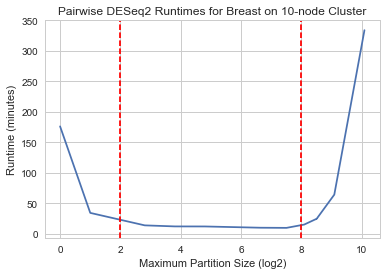

In [28]:
plt.plot(np.log2(partitions), new_times)
plt.axvline(2, ls='--', c='r')
plt.axvline(8, ls='--', c='r')
plt.ylabel('Runtime (minutes)')
plt.xlabel('Maximum Partition Size (log2)')
plt.title('Pairwise DESeq2 Runtimes for Breast on 10-node Cluster');

Traditional method takes by far the longest (5.5 hours), but the pairwise method with a partition of 1 also performs pretty poorly, which is fine because that method also produces results that are discordant from the traditional method. Our runtime optimum is reached with a partition size between $2^2$ and $2^8$ (4 - 256).

## Concordance

In [40]:
def rank(ref_genes, genes_to_rank):
    temp = {}
    ranks = []
    inter = set(ref_genes).intersection(set(genes_to_rank))
    ref_genes = [x for x in ref_genes if x in inter]
    genes_to_rank = [x for x in genes_to_rank if x in inter]
    # print 'Length of intersection: {}'.format(len(inter))
    for i, gene in enumerate(ref_genes):
        temp[gene] = i
    for gene in genes_to_rank:
        ranks.append(temp[gene])
    return ranks

def plot_ranks(ref_genes, genes_to_rank, title, ax):
    ranks = rank(ref_genes, genes_to_rank)
    x = np.array([x for x in xrange(len(ranks))])
    y = np.array(ranks)
    # sns.kdeplot(x, y, ax=ax)
    sns.regplot(x, y, ax=ax, scatter_kws={'alpha':0.03})
    ax.set_title(title)
    
def get_gene_lists(results):
    genes = defaultdict(list)
    for name in results:
        tissue = os.path.basename(name).split('-')[0].split('.tsv')[0]
        with open(name, 'r') as f:
            f.readline()
            for line in f:
                genes[tissue].append(line.split('\t')[0])
    return genes

In [10]:
np_breast = pd.read_csv('nonpairwise-results/breast.tsv', sep='\t', index_col=0)
breast = {int(x.split('-')[1][:-4]): pd.read_csv('max-chunk-results/' + x, sep='\t', index_col=0) 
          for x in os.listdir("max-chunk-results/") if 'breast' in x}

### Sorting by Pvalue Count

A collaborator suggested a method where for a given pariwise comparison, any gene considered significant is "binned", and the final set of genes are sorted by this "pvalue count", which intuitively represents the idea, "The number of times this gene was found significant across all comparisons."

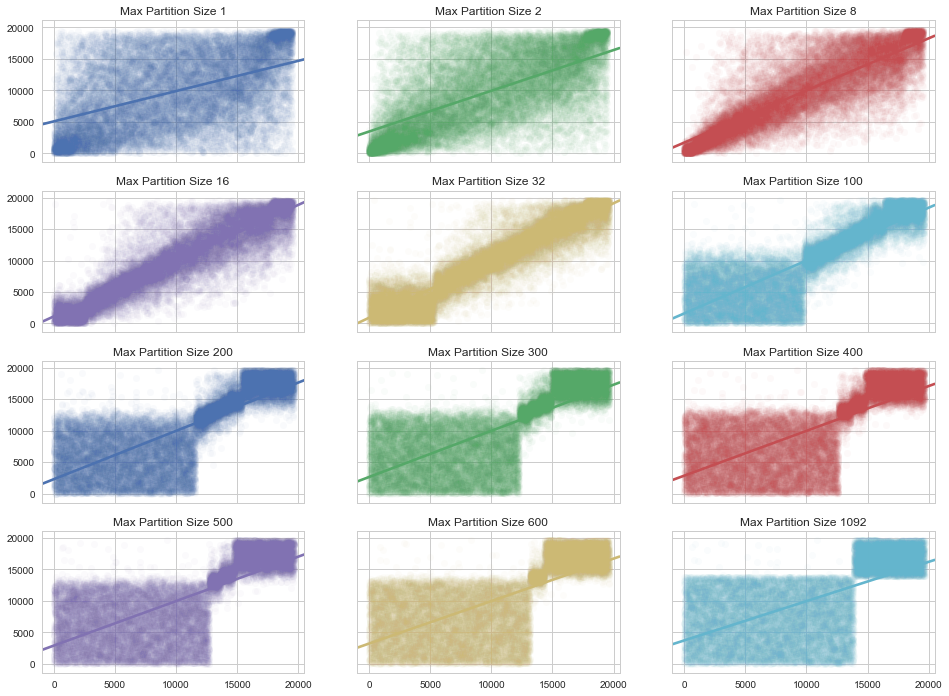

In [41]:
f, axes = plt.subplots(4, 3, figsize=(16, 12), sharex=True, sharey=True)
axes = axes.flatten()
for i, max_chunk in enumerate(sorted(breast.keys(), key=lambda x: int(x))):
    plot_ranks(np_breast.geneId, breast[max_chunk].index, 'Max Partition Size ' + str(max_chunk), axes[i])

Concordance when sorting by "Pvalue count" ends up with some bizarre results. Let's examine the same dataset, but sorting by averaged p-value. 

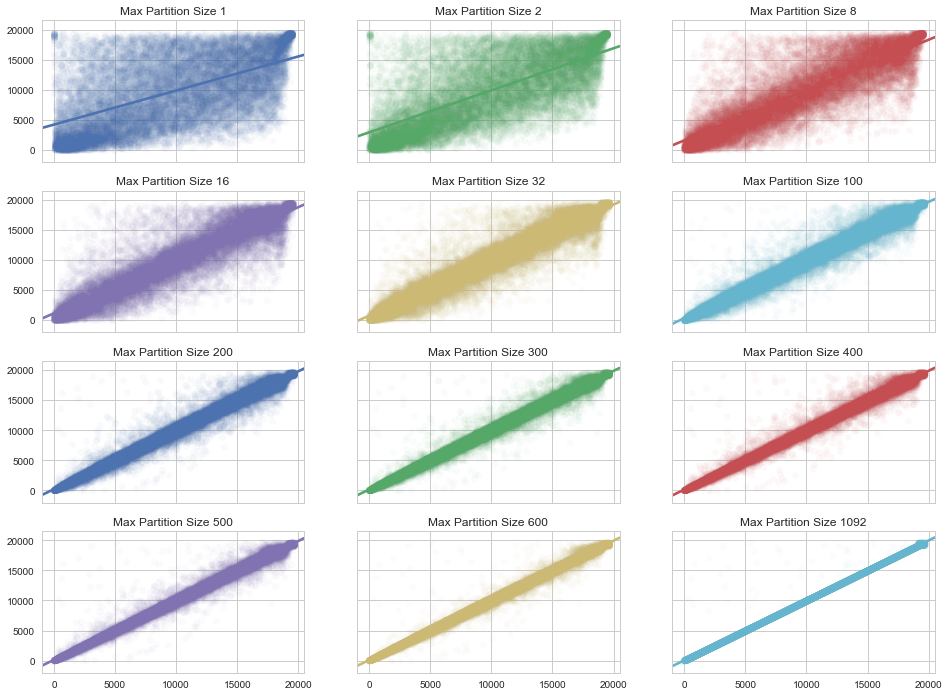

In [43]:
f, axes = plt.subplots(4, 3, figsize=(16, 12), sharex=True, sharey=True)
axes = axes.flatten()
for i, max_chunk in enumerate(sorted(breast.keys(), key=lambda x: int(x))):
    plot_ranks(np_breast.geneId, breast[max_chunk].sort_values('pval').index, 'Max Partition Size ' + str(max_chunk), axes[i])

Much better! Let's plot the pearson correlation as a function of the partition score

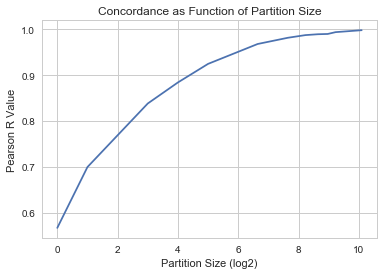

In [44]:
ps = []
for max_chunk in sorted(breast.keys(), key=lambda x: int(x)):
    r = rank(np_breast.geneId, breast[max_chunk].sort_values('pval').index)
    ps.append(pearsonr(np.array([x for x in xrange(len(r))]), np.array(r))[0])
plt.plot(np.log2([int(x) for x in sorted(breast.keys(), key=lambda x: int(x))]), ps)
plt.xlabel('Partition Size (log2)')
plt.ylabel('Pearson R Value')
plt.title('Concordance as Function of Partition Size');

# Pval Recombination With Weights

Example:
- Group A: 100, Group B: 530
- Max-Partition size: 16
- Optimum: 14
- Remainder: 12
- ($N_c$) Number of groups size 14: 37
- ($N_r$) Number of groups size 12: 1
- $N$ Number of total groups (38 in this example)
- $w$ = Vector of weights. 37 weights of (14/530) and one weight of (12/530)
- $p$ = Vector of pvals for each of the groups

Calculating the combined pval by weight is

$$ \hat{p} = \sum_{i=1}^{N} w_i * p_i $$

or as vectors:

$$ \hat{p} = \vec{w} \cdot \vec{p} $$


# Max Value as a Function of Partition Score

To visualize how the partition size is determined given a group size $N$ and maximum partition size $M$. 

In [58]:
def plot_max_val(N, max_partition):
    max_vals = []
    max_val = 0
    partition = None
    remainder = None
    temp = max_partition
    for i in xrange(temp):
        r = N % temp
        r = temp if r == 0 else r
        max_vals.append(r + temp)
        if r + temp >= max_val:
            max_val = r + temp
            partition = temp
            remainder = r
        temp -= 1
    print max_partition
    plt.plot([x for x in xrange(max_partition)], max_vals[::-1])
    plt.gca().invert_xaxis()
    plt.title('P: {}  R: {}   N: {}   M: {}'.format(partition, remainder, N, max_val))
    plt.xlabel('Partition Size')
    plt.ylabel('Max Value Score')

16


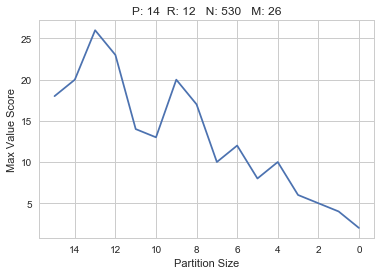

In [59]:
plot_max_val(N=530, max_partition=16)

$N$ of 530 and a max partition size of 16 gives us a maximum value of 26 when there are thirty-seven groups of size 14 and a single group of size 12.